In [1]:
import glob
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import random
import matplotlib.pyplot as plt
import datetime
from typing import Union, List, Tuple
import os
import time
from keras.models import Model
from keras.layers import (BatchNormalization, Flatten, Input, Reshape, Dense, MaxPool2D, Conv1D, Concatenate, Activation)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_probability as tfp
import seaborn as sns

pi = 3.14159265359
maxval = 1e9
minval = 1e-9

In [2]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [3]:
def inverse_cot(cota):
    a = np.arctan(1/cota)
    a[np.where(a<0)] = a[np.where(a<0)]+pi
    return a

In [4]:
X_train = train_df.drop(columns=['y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-midplane','cotBeta']).values

y_train = inverse_cot(abs(train_df['cotBeta'].values))*2/pi
y_test = inverse_cot(abs(test_df['cotBeta'].values))*2/pi

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_6369/2672626872.py:2: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1/cota)


In [5]:
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])
print(X_train.shape,X_test.shape)

(252613, 13) (50486, 13)


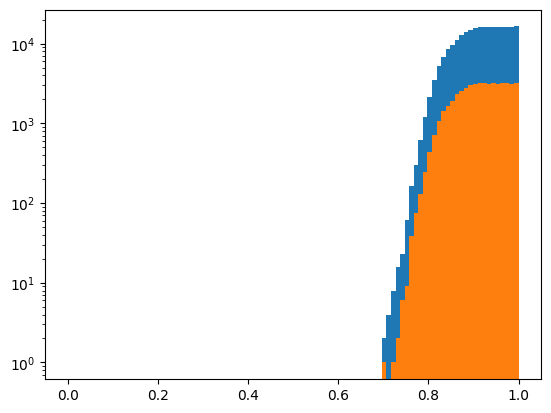

In [6]:
plt.hist(y_train,bins=np.linspace(0,1,100));
plt.hist(y_test,bins=np.linspace(0,1,100));
plt.yscale('log')

In [7]:
def param_transform(par):
    return minval+tf.math.softplus(par)

def beta_loss(y, p):
    
    alpha = param_transform(tf.gather(params=p, indices=[0], axis=1))
    beta = param_transform(tf.gather(params=p, indices=[1], axis=1))
    
    dist = tfp.distributions.Beta(concentration1 = alpha,
                                  concentration0 = beta)
    
    likelihood = dist.prob(y)  
    likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*tf.math.log(likelihood)
    return tf.keras.backend.sum(NLL,axis=1)    

In [8]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("relu", name="relu1")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense2")(x)
    x = Activation("relu", name="relu2")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense3")(x)
    x = Activation("relu", name="relu3")(x)
    x = BatchNormalization()(x)
    x = Dense(2, name="dense4")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=beta_loss)

model.summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                896       
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 relu2 (Activation)          (None, 64)                0         
                               

2023-02-10 15:08:32.325514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-10 15:08:32.325951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
es = EarlyStopping(patience=20,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/500


2023-02-10 15:08:32.558317: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-10 15:08:33.068124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


198/198 [==============================] - ETA: 0s - loss: -0.8199

2023-02-10 15:08:37.356987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


198/198 [==============================] - 6s 23ms/step - loss: -0.8199 - val_loss: -1.1964
Epoch 2/500
198/198 [==============================] - 4s 20ms/step - loss: -1.4194 - val_loss: -1.5795
Epoch 3/500
198/198 [==============================] - 4s 19ms/step - loss: -1.7076 - val_loss: -1.7808
Epoch 4/500
198/198 [==============================] - 4s 19ms/step - loss: -1.8910 - val_loss: -1.9448
Epoch 5/500
198/198 [==============================] - 4s 20ms/step - loss: -2.0210 - val_loss: -2.0476
Epoch 6/500
198/198 [==============================] - 4s 20ms/step - loss: -2.1192 - val_loss: -2.1438
Epoch 7/500
198/198 [==============================] - 4s 20ms/step - loss: -2.1959 - val_loss: -2.2061
Epoch 8/500
198/198 [==============================] - 4s 20ms/step - loss: -2.2554 - val_loss: -2.2655
Epoch 9/500
198/198 [==============================] - 4s 19ms/step - loss: -2.3064 - val_loss: -2.3213
Epoch 10/500
198/198 [==============================] - 4s 19ms/step - loss:

198/198 [==============================] - 4s 19ms/step - loss: -2.7886 - val_loss: -2.7771
Epoch 80/500
198/198 [==============================] - 4s 19ms/step - loss: -2.7812 - val_loss: -2.7822
Epoch 81/500
198/198 [==============================] - 4s 19ms/step - loss: -2.7867 - val_loss: -2.7868
Epoch 82/500
198/198 [==============================] - 4s 19ms/step - loss: -2.7869 - val_loss: -2.7778
Epoch 83/500
198/198 [==============================] - 4s 19ms/step - loss: -2.7900 - val_loss: -2.7597
Epoch 84/500
198/198 [==============================] - 4s 19ms/step - loss: -2.7902 - val_loss: -2.7747
Epoch 85/500
198/198 [==============================] - 4s 19ms/step - loss: -2.7900 - val_loss: -2.7763
Epoch 86/500
198/198 [==============================] - 4s 19ms/step - loss: -2.7926 - val_loss: -2.7761
Epoch 87/500
198/198 [==============================] - 4s 19ms/step - loss: -2.7904 - val_loss: -2.7941
Epoch 88/500
198/198 [==============================] - 4s 19ms/step

198/198 [==============================] - 4s 19ms/step - loss: -2.8393 - val_loss: -2.8210
Epoch 157/500
198/198 [==============================] - 4s 20ms/step - loss: -2.8353 - val_loss: -2.8152
Epoch 158/500
198/198 [==============================] - 4s 19ms/step - loss: -2.8374 - val_loss: -2.8311
Epoch 159/500
198/198 [==============================] - 4s 19ms/step - loss: -2.8332 - val_loss: -2.8246
Epoch 160/500
198/198 [==============================] - 4s 20ms/step - loss: -2.8389 - val_loss: -2.8411
Epoch 161/500
198/198 [==============================] - 4s 19ms/step - loss: -2.8383 - val_loss: -2.8337
Epoch 162/500
198/198 [==============================] - 4s 19ms/step - loss: -2.8399 - val_loss: -2.8319
Epoch 163/500
198/198 [==============================] - 4s 19ms/step - loss: -2.8384 - val_loss: -2.8353
Epoch 164/500
198/198 [==============================] - 4s 19ms/step - loss: -2.8434 - val_loss: -2.8347
Epoch 165/500
198/198 [==============================] - 4s 

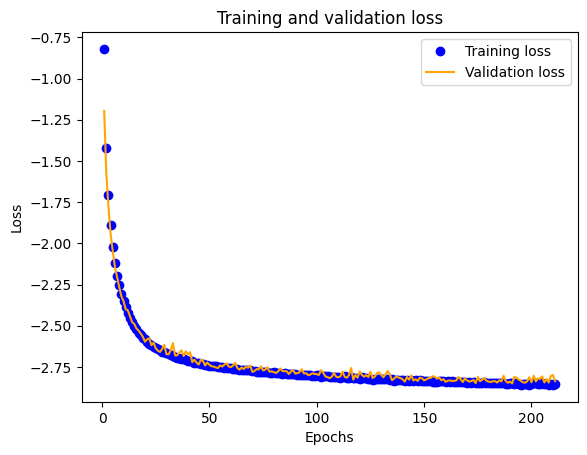

In [10]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

In [11]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['par1','par2'])
df['Btrue'] = y_test*pi/2
df['alpha'] = param_transform(df['par1'])
df['beta'] = param_transform(df['par2'])

dist = tfp.distributions.Beta(concentration1 = df['alpha'], concentration0 = df['beta'])
    
df['mean'] = dist.mean()*pi/2
df['mode'] = dist.mode()*pi/2
df['sigma'] = dist.stddev()*pi/2

df.to_csv("test_1DcotBBeta.csv",header=False,index=False)

  41/1578 [..............................] - ETA: 3s

2023-02-10 15:21:59.312801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1578/1578 [==============================] - 4s 2ms/step


In [12]:
residuals = df['Btrue'] - df['mode']
print(np.mean(residuals),np.std(residuals))

-0.009477958316823002 0.028633702129277898


/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_6369/504458315.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


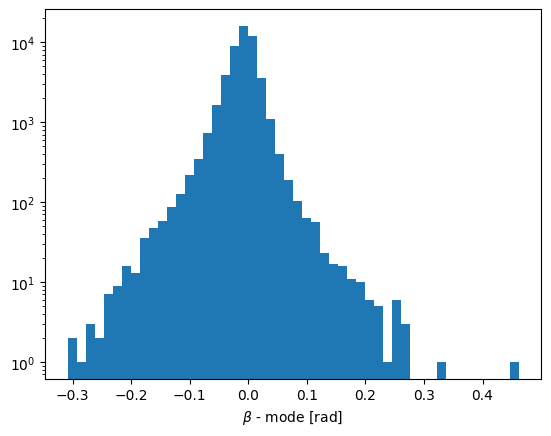

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_6369/504458315.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


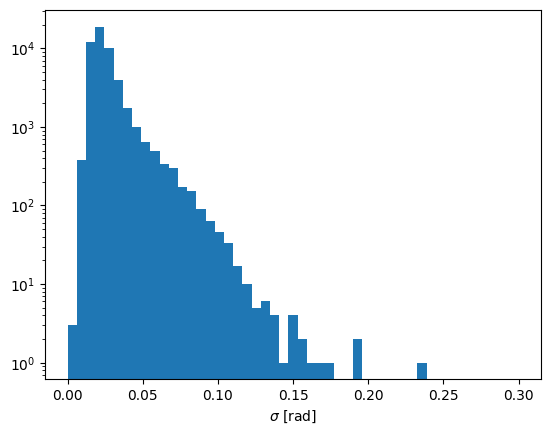

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_6369/504458315.py:12: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


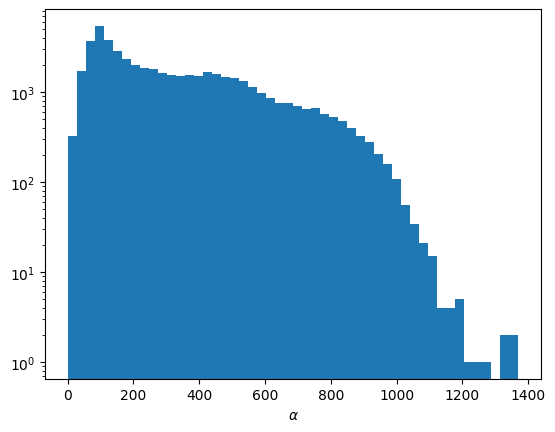

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_6369/504458315.py:17: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


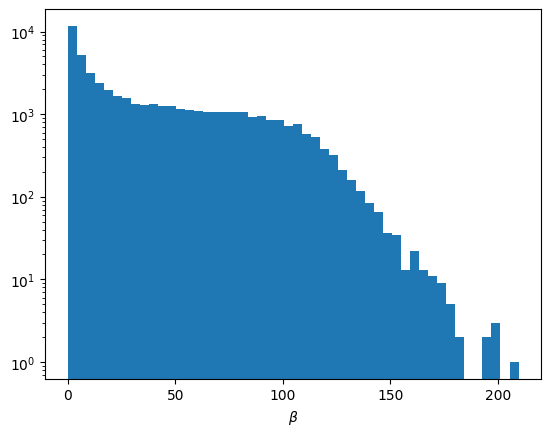

In [13]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$ - mode [rad]')
plt.show()

plt.hist(df['sigma'],bins=np.linspace(0,0.3,50));
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [rad]')
plt.show()

plt.hist(df['alpha'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha$')
plt.show()

plt.hist(df['beta'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$')
plt.show()

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_6369/2827940454.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


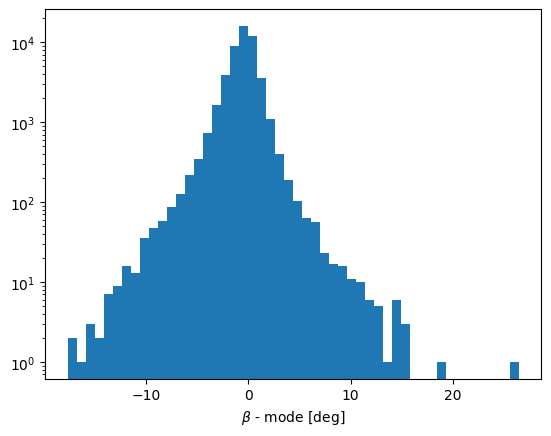

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_6369/2827940454.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


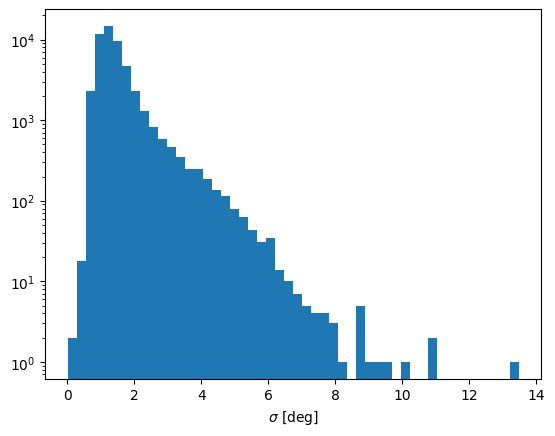

In [14]:
plt.hist(residuals*180/pi,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$ - mode [deg]')
plt.show()

plt.hist(df['sigma']*180/pi,bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [deg]')
plt.show()

Text(0, 0.5, 'log(beta)')

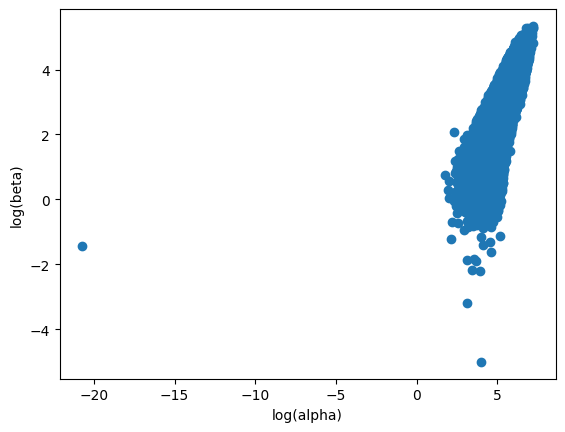

In [15]:
plt.scatter(np.log(df['alpha']),np.log(df['beta']))
plt.xlabel('log(alpha)')
plt.ylabel('log(beta)')

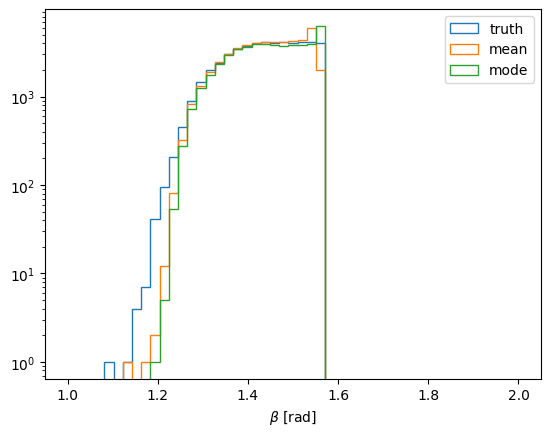

In [16]:
plt.hist(df['Btrue'],bins=np.linspace(1,2,50),histtype='step',label='truth')
plt.hist(df['mean'],bins=np.linspace(1,2,50),histtype='step',label='mean')
plt.hist(df['mode'],bins=np.linspace(1,2,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\beta$ [rad]')
plt.legend()
plt.yscale('log')
plt.show()

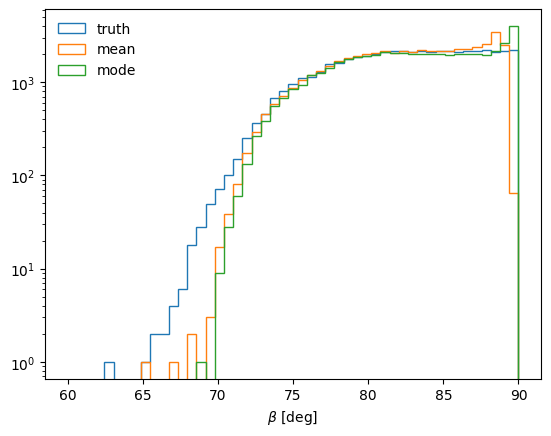

In [17]:
plt.hist(df['Btrue']*180/pi,bins=np.linspace(60,90,50),histtype='step',label='truth')
plt.hist(df['mean']*180/pi,bins=np.linspace(60,90,50),histtype='step',label='mean')
plt.hist(df['mode']*180/pi,bins=np.linspace(60,90,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\beta$ [deg]')
plt.legend(frameon=False,loc='upper left')
plt.yscale('log')
plt.show()

Text(0, 0.5, '$\\beta$ - mode [rad]')

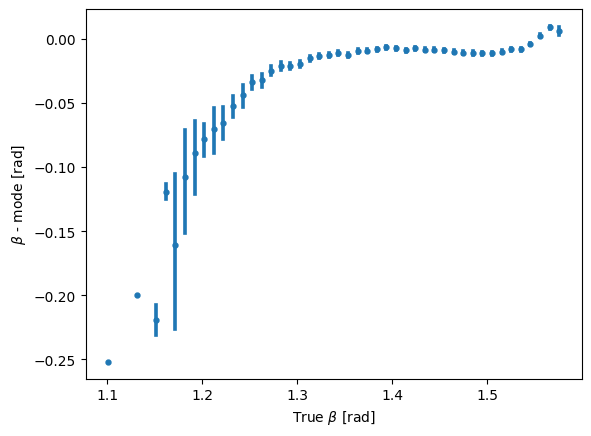

In [18]:
x = sns.regplot(x=df['Btrue'], y=df['Btrue']-df['mode'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\beta$ - mode [rad]')

Text(0, 0.5, '$\\beta$ - mode [deg]')

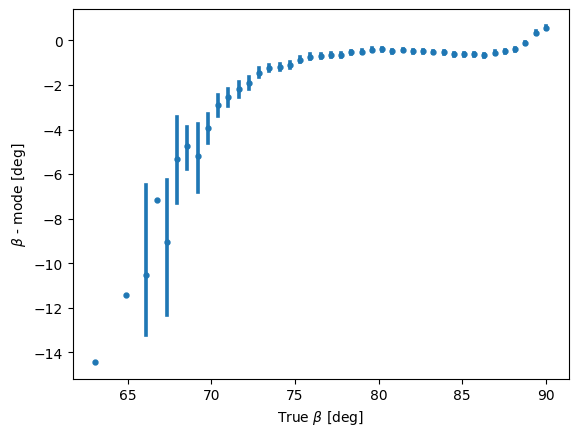

In [19]:
x = sns.regplot(x=df['Btrue']*180/pi, y=(df['Btrue']-df['mode'])*180/pi, x_bins=np.linspace(60,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [deg]')
plt.ylabel(r'$\beta$ - mode [deg]')

Text(0, 0.5, '$\\beta$ - mode [rad]')

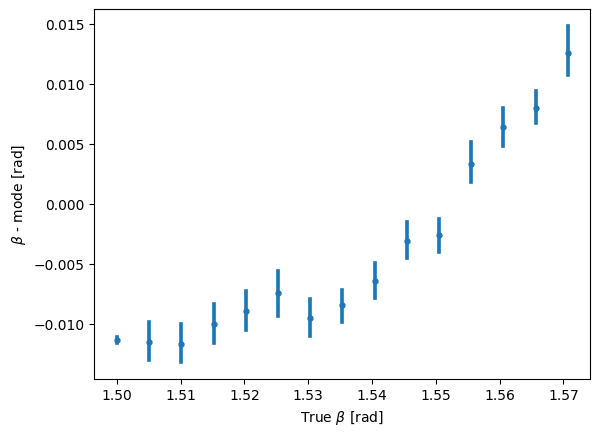

In [20]:
x = sns.regplot(x=df['Btrue'], y=df['Btrue']-df['mode'], x_bins=np.linspace(1.5,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\beta$ - mode [rad]')

Text(0, 0.5, '$\\beta$ - mode [deg]')

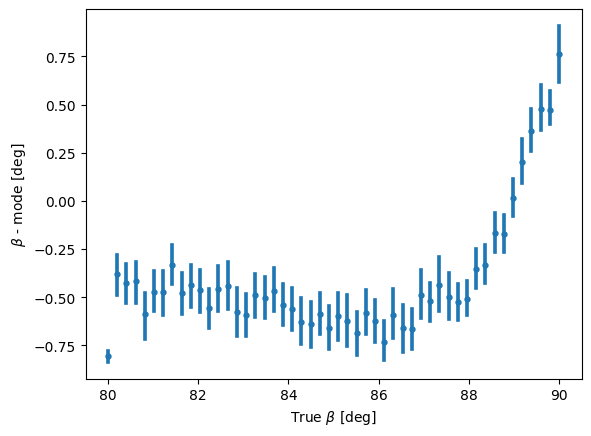

In [21]:
x = sns.regplot(x=df['Btrue']*180/pi, y=(df['Btrue']-df['mode'])*180/pi, x_bins=np.linspace(80,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [deg]')
plt.ylabel(r'$\beta$ - mode [deg]')

Text(0, 0.5, '$\\sigma$ [rad]')

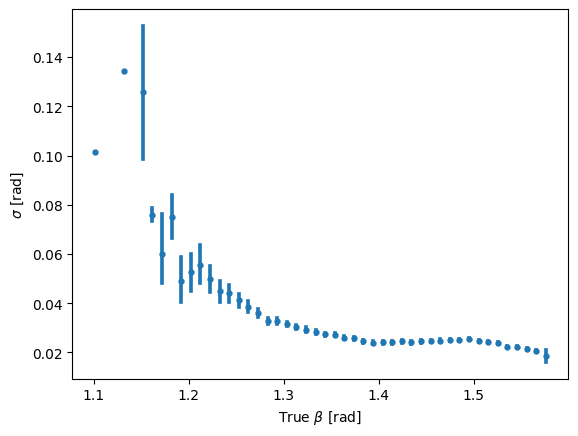

In [22]:
y = sns.regplot(x=df['Btrue'], y=df['sigma'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\sigma$ [rad]')

Text(0, 0.5, '$\\sigma$ [deg]')

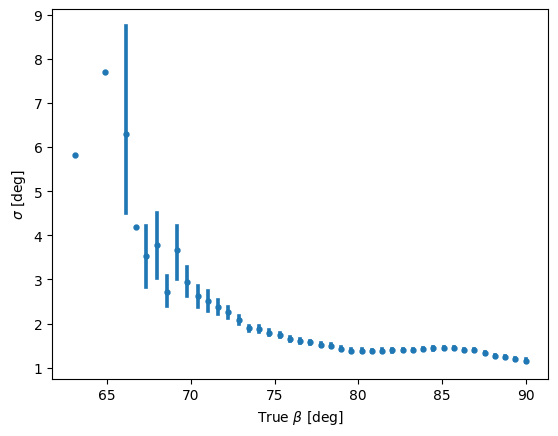

In [23]:
y = sns.regplot(x=df['Btrue']*180/pi, y=df['sigma']*180/pi, x_bins=np.linspace(60,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [deg]')
plt.ylabel(r'$\sigma$ [deg]')

In [24]:
pulls = residuals/df['sigma']

Text(0.5, 0, 'pull')

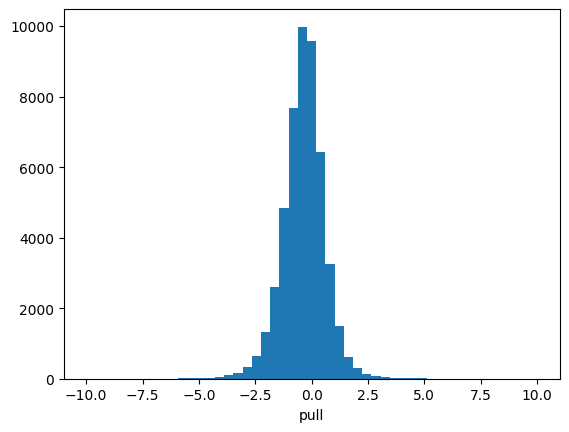

In [25]:
plt.hist(pulls,bins=np.linspace(-10,10,50));
plt.xlabel('pull')

In [26]:
print(np.mean(pulls),np.std(pulls))

-0.35262707925714576 0.9529791284621542
